In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 96 kB 4.2 MB/s 


In [ ]:
import os 

# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

# the base Google Drive directory
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved
project_folder = "Colab Notebooks/NewApproachExperiments/"


def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)


Your working directory was changed to /content/drive/My Drive/Colab Notebooks/NewApproachExperiments/

An empty text file was created there. You can also run !pwd to confirm the current working directory.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM , Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_squared_error, r2_score, mean_absolute_error, max_error
import pandas as pd 
import pandas as pd 
import keras_tuner as kt
import tensorflow as tf 
from tensorflow import keras




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load the dataset
dataframe = pandas.read_csv('/content/drive/MyDrive/Rainfallprediction/2013/Percip2013UHL.csv', index_col= 0 , header= 0)

In [ ]:
# , usecols=[1], engine='python'
dataframe= dataframe[ (dataframe['Time_Tag']  > '2013-04-09') & (dataframe['Time_Tag']  < '2013-11-03') ]
dataframe.head(5)

,StationID,Time_Tag,MeasuredValue,MissIndex
1,HY033,2013-04-09 12:10:00,0.0,0
2,HY033,2013-04-09 12:25:00,0.0,0
3,HY033,2013-04-09 12:40:00,0.0,0
4,HY033,2013-04-09 12:55:00,0.0,0
5,HY033,2013-04-09 13:10:00,0.0,0


In [ ]:
dataset = dataframe.MeasuredValue
dataset = dataset.astype('float32')

In [ ]:
dataset

1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
        ... 
19916    0.0
19917    0.0
19918    0.0
19919    0.0
19920    0.0
Name: MeasuredValue, Length: 19920, dtype: float32

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:]
print(len(train), len(test))#13944

13944 5976


In [ ]:
dataset

1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
        ... 
19916    0.0
19917    0.0
19918    0.0
19919    0.0
19920    0.0
Name: MeasuredValue, Length: 19920, dtype: float32

In [ ]:
train

1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
        ... 
13940    0.0
13941    0.0
13942    0.0
13943    0.0
13944    0.0
Name: MeasuredValue, Length: 13944, dtype: float32

In [ ]:
np.array(train).reshape(-1, 1)

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)).fit(np.array(train).reshape(-1, 1))
train = scaler.transform(np.array(train).reshape(-1, 1))
test = scaler.transform(np.array(test).reshape(-1, 1))

In [ ]:
train.shape

(13944, 1)

In [ ]:
test.shape

(5976, 1)

In [ ]:
# Function to create train, test data
def create_dataset(dataset, look_back=1 , leadsteps=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-leadsteps):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back + (leadsteps-1) , 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
np.random.seed(7)

look_back = 10
trainX, trainY = create_dataset(train, look_back )
testX, testY = create_dataset(test, look_back )

In [ ]:
trainY

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
testX.shape

(5965, 10)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1] , 1))
testX = np.reshape(testX, (testX.shape[0] , testX.shape[1] , 1))

In [ ]:
from kerastuner import HyperModel
class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
    def build(self, hp):
        model = Sequential()
        model.add(
              LSTM(
                units=hp.Int('units', 2, 5, 1, default=4),

                input_shape=input_shape
            )
        )
        
        
        model.add(Dense(1,
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu','tanh' 'sigmoid'],
                    default='relu')
        ))
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss='mse',metrics=['mse']
        )
        
        return model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [ ]:
input_shape = ( look_back , 1)
hypermodel = LSTMHyperModel(input_shape)

In [ ]:
from kerastuner import BayesianOptimization
tuner_bo = BayesianOptimization(
            hypermodel,
            objective='mse',
            max_trials=5,
            seed=7,
            executions_per_trial=2,
            overwrite=True 
            )
tuner_bo.search(trainX, trainY, epochs=200,   batch_size=16,   use_multiprocessing=True  , verbose=2 )


Trial 5 Complete [00h 25m 14s]
mse: 0.0002826775162247941

Best mse So Far: 0.00025392143288627267
Total elapsed time: 02h 07m 38s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_model = tuner_bo.get_best_models(num_models=1)[0]


In [ ]:
best_model.build(trainX.shape)

In [ ]:
best_hp = tuner_bo.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
#15 min Model for testing ouliers 
best_hp.values

{'dense_activation': 'sigmoid', 'learning_rate': 0.01, 'units': 5}

In [ ]:
#15 min 
best_hp.values

{'dense_activation': 'tanh', 'learning_rate': 0.01, 'units': 5}

In [ ]:
#30 min 
best_hp.values

{'dense_activation': 'sigmoid', 'learning_rate': 0.01, 'units': 5}

In [ ]:
#45 min 
best_hp.values

{'dense_activation': 'relu', 'learning_rate': 0.01, 'units': 2}

In [ ]:
#60 min 
best_hp.values

{'dense_activation': 'sigmoid', 'learning_rate': 0.01, 'units': 4}

In [ ]:
test2Predict = best_model.predict(testX)

In [ ]:
def evaluate_model(testY , test2Predict , testshape):
  testY = scaler.inverse_transform(testY.reshape((testshape,1)))
  test2Predict = scaler.inverse_transform(test2Predict.reshape((testshape,1)))

  # Scores on rain and no rain tuples 
  test = testY[: , 0]
  predictions = test2Predict[:,0]
  mre_score = max_error (test, predictions)
  print('Test MRE: %.3f' % mre_score) 
  mae_score = mean_absolute_error (test, predictions)
  print('Test MAE: %.3f' % mae_score)
  rmse_score = np.sqrt(mean_squared_error( test, predictions))
  print('Test RMSE: %.3f' % rmse_score)
  r2 = r2_score(test, predictions)
  print('Test R2: %.3f' % r2)


  # Scores on rain and no rain tuples 
  results  = pd.DataFrame( { 'true' :test , 'prediction':predictions } )
  print ("Scores on rain tuples \n")

  results_true_rain = results[results['true']!=0].true
  results_prediction_rain = results[results['true']!=0].prediction
  mre_score = max_error ( results_true_rain,results_prediction_rain )
  print('Test MRE: %.3f' % mre_score)
  mae_score = mean_absolute_error (results_true_rain, results_prediction_rain)
  print('Test MAE: %.3f' % mae_score)
  rmse_score = np.sqrt(mean_squared_error( results_true_rain, results_prediction_rain))
  print('Test RMSE: %.3f' % rmse_score)
  r2 = r2_score(results_true_rain, results_prediction_rain)
  print('Test R2: %.3f' % r2)


  print ("\n Scores on no-rain tuples \n")
  results_true_no_rain = results[results['true']==0].true
  results_prediction_no_rain = results[results['true']==0].prediction

  mre_score = max_error (results_true_no_rain, results_prediction_no_rain)
  print('Test MRE: %.3f' % mre_score)
  mae_score = mean_absolute_error (results_true_no_rain, results_prediction_no_rain)
  print('Test MAE: %.3f' % mae_score)
  rmse_score = np.sqrt(mean_squared_error( results_true_no_rain, results_prediction_no_rain))
  print('Test RMSE: %.3f' % rmse_score)
  r2 = r2_score(results_true_no_rain, results_prediction_no_rain)
  print('Test R2: %.3f' % r2)





Results 15 min data

In [ ]:
evaluate_model( testY , test2Predict , testY.shape[0])

Test MRE: 8.963
Test MAE: 0.035
Test RMSE: 0.201
Test R2: 0.023
Scores on rain tuples 

Test MRE: 8.963
Test MAE: 0.505
Test RMSE: 0.826
Test R2: -0.557

 Scores on no-rain tuples 

Test MRE: 0.122
Test MAE: 0.005
Test RMSE: 0.007
Test R2: 0.000


Results 30 min 

In [ ]:
evaluate_model( testY , test2Predict ,testY.shape[0])

Test MRE: 13.011
Test MAE: 0.031
Test RMSE: 0.264
Test R2: 0.148
Scores on rain tuples 

Test MRE: 13.011
Test MAE: 0.536
Test RMSE: 1.216
Test R2: -0.095

 Scores on no-rain tuples 

Test MRE: 1.093
Test MAE: 0.007
Test RMSE: 0.050
Test R2: 0.000


Results 45 min 

In [ ]:
evaluate_model( testY , test2Predict ,testY.shape[0])

Test MRE: 13.200
Test MAE: 0.035
Test RMSE: 0.273
Test R2: 0.087
Scores on rain tuples 

Test MRE: 13.200
Test MAE: 0.555
Test RMSE: 1.247
Test R2: -0.152

 Scores on no-rain tuples 

Test MRE: 0.974
Test MAE: 0.010
Test RMSE: 0.065
Test R2: 0.000


Results 60 min 

In [ ]:
evaluate_model( testY , test2Predict ,testY.shape[0])

Test MRE: 12.953
Test MAE: 0.033
Test RMSE: 0.276
Test R2: 0.067
Scores on rain tuples 

Test MRE: 12.953
Test MAE: 0.580
Test RMSE: 1.280
Test R2: -0.209

 Scores on no-rain tuples 

Test MRE: 0.798
Test MAE: 0.007
Test RMSE: 0.046
Test R2: 0.000


Old version

In [ ]:
# create and fit the LSTM network

#checking reproduciblityy
model = Sequential()
#model.add(LSTM(3, input_shape=( look_back , 1) , return_sequences=True))
#model.add(LSTM(4, input_shape=( look_back , 1) ))
#testing 2 layrs
#model.add(LSTM(4, input_shape=( look_back , 1) , return_sequences=True))
#model.add(LSTM(2, input_shape=( look_back , 1) ))
#Back to one layer
#model.add(Bidirectional( LSTM(4, input_shape=( look_back , 1))))
model.add(LSTM(4, input_shape=( look_back , 1) ))
model.add(Dense(1))
#opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer= 'adam' )
history = model.fit(trainX, trainY, epochs= 200  , batch_size=1, verbose=2 )

Epoch 1/200
13933/13933 - 41s - loss: 4.3256e-04
Epoch 2/200
13933/13933 - 24s - loss: 4.0130e-04
Epoch 3/200
13933/13933 - 24s - loss: 3.9196e-04
Epoch 4/200
13933/13933 - 24s - loss: 3.8716e-04
Epoch 5/200
13933/13933 - 25s - loss: 3.7476e-04
Epoch 6/200
13933/13933 - 25s - loss: 3.8348e-04
Epoch 7/200
13933/13933 - 25s - loss: 3.6976e-04
Epoch 8/200
13933/13933 - 25s - loss: 3.7677e-04
Epoch 9/200
13933/13933 - 24s - loss: 3.8109e-04
Epoch 10/200
13933/13933 - 25s - loss: 3.7600e-04
Epoch 11/200
13933/13933 - 25s - loss: 3.7817e-04
Epoch 12/200
13933/13933 - 24s - loss: 3.7725e-04
Epoch 13/200
13933/13933 - 25s - loss: 3.8009e-04
Epoch 14/200
13933/13933 - 24s - loss: 3.7170e-04
Epoch 15/200
13933/13933 - 24s - loss: 3.7981e-04
Epoch 16/200
13933/13933 - 24s - loss: 3.7773e-04
Epoch 17/200
13933/13933 - 24s - loss: 3.7951e-04
Epoch 18/200
13933/13933 - 24s - loss: 3.7666e-04
Epoch 19/200
13933/13933 - 24s - loss: 3.7772e-04
Epoch 20/200
13933/13933 - 24s - loss: 3.7113e-04
Epoch 21/

In [ ]:
# create and fit the LSTM network
model = Sequential()
#model.add(LSTM(3, input_shape=( look_back , 1) , return_sequences=True))
#model.add(LSTM(4, input_shape=( look_back , 1) ))
#testing 2 layrs
#model.add(LSTM(4, input_shape=( look_back , 1) , return_sequences=True))
#model.add(LSTM(2, input_shape=( look_back , 1) ))
#Back to one layer
#model.add(Bidirectional( LSTM(4, input_shape=( look_back , 1))))
model.add(LSTM(4, input_shape=( look_back , 1) ))
model.add(Dense(1))
#opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer= 'adam' )
history = model.fit(trainX, trainY, epochs= 200  , batch_size=1, verbose=2 )

Epoch 1/200
13933/13933 - 57s - loss: 4.2588e-04
Epoch 2/200
13933/13933 - 35s - loss: 4.0187e-04
Epoch 3/200
13933/13933 - 35s - loss: 3.8207e-04
Epoch 4/200
13933/13933 - 35s - loss: 3.8832e-04
Epoch 5/200
13933/13933 - 35s - loss: 3.8315e-04
Epoch 6/200
13933/13933 - 35s - loss: 3.8688e-04
Epoch 7/200
13933/13933 - 35s - loss: 3.8206e-04
Epoch 8/200
13933/13933 - 35s - loss: 3.8339e-04
Epoch 9/200
13933/13933 - 35s - loss: 3.7729e-04
Epoch 10/200
13933/13933 - 35s - loss: 3.8242e-04
Epoch 11/200
13933/13933 - 35s - loss: 3.8017e-04
Epoch 12/200
13933/13933 - 35s - loss: 3.8186e-04
Epoch 13/200
13933/13933 - 35s - loss: 3.8157e-04
Epoch 14/200
13933/13933 - 35s - loss: 3.7720e-04
Epoch 15/200
13933/13933 - 35s - loss: 3.8094e-04
Epoch 16/200
13933/13933 - 35s - loss: 3.7012e-04
Epoch 17/200
13933/13933 - 35s - loss: 3.8115e-04
Epoch 18/200
13933/13933 - 35s - loss: 3.7223e-04
Epoch 19/200
13933/13933 - 35s - loss: 3.7438e-04
Epoch 20/200
13933/13933 - 35s - loss: 3.7836e-04
Epoch 21/

In [ ]:
trainY.shape

(13933,)

In [ ]:
testY.shape

(5965,)

In [ ]:
# make predictions new 
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY.reshape((13933, 1)))
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY.reshape((5965,1)))
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[: , 0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[: , 0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))



Train Score: 0.31 RMSE
Test Score: 0.18 RMSE


In [ ]:
testY.shape

(5971,)

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY.reshape((13933, 1)))
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY.reshape((5965,1)))
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[: , 0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[: , 0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 0.30 RMSE
Test Score: 0.17 RMSE


In [ ]:

# Scores on rain and no rain tuples seperately 
test = testY[: , 0]
predictions = testPredict[:,0]
mre_score = max_error (test, predictions)
print('Test MRE: %.3f' % mre_score)
mae_score = mean_absolute_error (test, predictions)
print('Test MAE: %.3f' % mae_score)
rmse_score = np.sqrt(mean_squared_error( test, predictions))
print('Test RMSE: %.3f' % rmse_score)
r2 = r2_score(test, predictions)
print('Test R2: %.3f' % r2)


results  = pd.DataFrame( { 'true' :test , 'prediction':predictions } )
print ("Scores on rain tuples \n")

results_true_rain = results[results['true']!=0].true
results_prediction_rain = results[results['true']!=0].prediction
mre_score = max_error ( results_true_rain,results_prediction_rain )
print('Test MRE: %.3f' % mre_score)
mae_score = mean_absolute_error (results_true_rain, results_prediction_rain)
print('Test MAE: %.3f' % mae_score)
rmse_score = np.sqrt(mean_squared_error( results_true_rain, results_prediction_rain))
print('Test RMSE: %.3f' % rmse_score)
r2 = r2_score(results_true_rain, results_prediction_rain)
print('Test R2: %.3f' % r2)


print ("\n Scores on no-rain tuples \n")
results_true_no_rain = results[results['true']==0].true
results_prediction_no_rain = results[results['true']==0].prediction

mre_score = max_error (results_true_no_rain, results_prediction_no_rain)
print('Test MRE: %.3f' % mre_score)
mae_score = mean_absolute_error (results_true_no_rain, results_prediction_no_rain)
print('Test MAE: %.3f' % mae_score)
rmse_score = np.sqrt(mean_squared_error( results_true_no_rain, results_prediction_no_rain))
print('Test RMSE: %.3f' % rmse_score)
r2 = r2_score(results_true_no_rain, results_prediction_no_rain)
print('Test R2: %.3f' % r2)



Test MRE: 8.399
Test MAE: 0.032
Test RMSE: 0.180
Test R2: 0.218
Scores on rain tuples 

Test MRE: 8.399
Test MAE: 0.383
Test RMSE: 0.707
Test R2: -0.139

 Scores on no-rain tuples 

Test MRE: 1.141
Test MAE: 0.010
Test RMSE: 0.055
Test R2: 0.000


Analysing errors 

In [ ]:
#Analysis of performance on Test data 
y = testY[: , 0]
y_hat = testPredict[: , 0]

In [ ]:
y_y_hat = pd.DataFrame({'y':y , 'y_hat':y_hat} )

In [ ]:
pd.set_option('display.max_rows', 100)

In [ ]:
for i in range (1,90):
  print (y[i])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.2
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [ ]:
y_y_hat.iloc[1:99]

,y,y_hat
1,0.0,0.101148
2,0.0,0.102440
3,0.0,0.023606
4,0.0,0.004690
5,0.0,0.018087
6,0.0,-0.008020
7,0.0,-0.003469
8,0.0,-0.005368
9,0.0,-0.007191
10,0.0,-0.007010


In [ ]:
y_y_hat

,y,y_hat
0,0.0,0.311304
1,0.0,0.101148
2,0.0,0.102440
3,0.0,0.023606
4,0.0,0.004690
...,...,...
5960,0.0,-0.007010
5961,0.0,-0.007010
5962,0.0,-0.007010
5963,0.0,-0.007010


In [ ]:
y_y_hat['residual_error'] = y_y_hat['y'] - y_y_hat['y_hat']

In [ ]:
y_y_hat.describe()

,y,y_hat,residual_error
count,5965.000000,5965.000000,5965.000000
mean,0.031182,0.017353,0.013829
std,0.203481,0.124898,0.173362
min,0.000000,-0.171421,-1.326600
25%,0.000000,-0.007010,0.007010
50%,0.000000,-0.007010,0.007010
75%,0.000000,-0.007010,0.007010
max,9.000000,2.126600,8.483362


In [ ]:
y_y_hat [abs(y_y_hat['residual_error'])>2]

,y,y_hat,residual_error
964,4.6,0.165393,4.434607
1829,9.0,0.516637,8.483362


In [ ]:
test = testY[: , 0]
predictions = testPredict[:,0]
mre_score = max_error (test, predictions)
print('Test MRE: %.3f' % mre_score)
mae_score = mean_absolute_error (test, predictions)
print('Test MAE: %.3f' % mae_score)
rmse_score = np.sqrt(mean_squared_error( test, predictions))
print('Test RMSE: %.3f' % rmse_score)
r2 = r2_score(test, predictions)
print('Test R2: %.3f' % r2)

Test MRE: 8.483
Test MAE: 0.035
Test RMSE: 0.174
Test R2: 0.269


In [ ]:
# Scores on rain and no rain tuples seperately 

results  = pd.DataFrame( { 'true' :test , 'prediction':predictions } )
print ("Scores on rain tuples \n")

results_true_rain = results[results['true']!=0].true
results_prediction_rain = results[results['true']!=0].prediction
mre_score = max_error ( results_true_rain,results_prediction_rain )
print('Test MRE: %.3f' % mre_score)
mae_score = mean_absolute_error (results_true_rain, results_prediction_rain)
print('Test MAE: %.3f' % mae_score)
rmse_score = np.sqrt(mean_squared_error( results_true_rain, results_prediction_rain))
print('Test RMSE: %.3f' % rmse_score)
r2 = r2_score(results_true_rain, results_prediction_rain)
print('Test R2: %.3f' % r2)


print ("\n Scores on no-rain tuples \n")
results_true_no_rain = results[results['true']==0].true
results_prediction_no_rain = results[results['true']==0].prediction

mre_score = max_error (results_true_no_rain, results_prediction_no_rain)
print('Test MRE: %.3f' % mre_score)
mae_score = mean_absolute_error (results_true_no_rain, results_prediction_no_rain)
print('Test MAE: %.3f' % mae_score)
rmse_score = np.sqrt(mean_squared_error( results_true_no_rain, results_prediction_no_rain))
print('Test RMSE: %.3f' % rmse_score)
r2 = r2_score(results_true_no_rain, results_prediction_no_rain)
print('Test R2: %.3f' % r2)


Scores on rain tuples 

Test MRE: 8.642
Test MAE: 0.449
Test RMSE: 0.758
Test R2: -0.311

 Scores on no-rain tuples 

Test MRE: 1.170
Test MAE: 0.094
Test RMSE: 0.099
Test R2: 0.000


dict_keys(['loss'])


KeyError: ignored

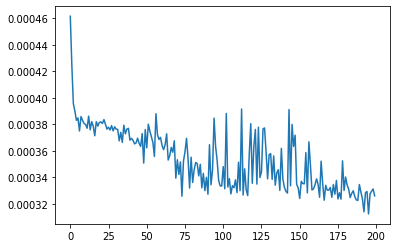

In [ ]:
# Fit the model
#history = model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

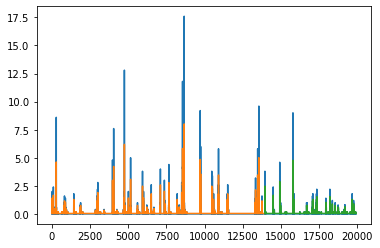

In [ ]:
# shift train predictions for plotting

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict.reshape(( 1 , 13942))
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1] = testPredict.reshape(( 1 , 5974))
# plot baseline and predictions
plt.plot(dataset ) 
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

15 min error analysis 

In [ ]:
evaluate_model( testY , test2Predict , testY.shape[0])

Test MRE: 13.520
Test MAE: 0.050
Test RMSE: 0.268
Test R2: -0.734
Scores on rain tuples 

Test MRE: 13.520
Test MAE: 0.440
Test RMSE: 1.083
Test R2: -1.676

 Scores on no-rain tuples 

Test MRE: 1.130
Test MAE: 0.026
Test RMSE: 0.050
Test R2: 0.000


In [ ]:
evaluate_model( testY , test2Predict , testY.shape[0])

Test MRE: 8.972
Test MAE: 0.031
Test RMSE: 0.201
Test R2: 0.020
Scores on rain tuples 

Test MRE: 8.972
Test MAE: 0.507
Test RMSE: 0.828
Test R2: -0.563

 Scores on no-rain tuples 

Test MRE: 0.064
Test MAE: 0.001
Test RMSE: 0.003
Test R2: 0.000


In [ ]:
evaluate_model( testY , test2Predict , testY.shape[0])

Test MRE: 13.520
Test MAE: 0.050
Test RMSE: 0.268
Test R2: -0.734
Scores on rain tuples 

Test MRE: 13.520
Test MAE: 0.440
Test RMSE: 1.083
Test R2: -1.676

 Scores on no-rain tuples 

Test MRE: 1.130
Test MAE: 0.026
Test RMSE: 0.050
Test R2: 0.000


In [ ]:
max (testY )

0.5113636

In [ ]:
max ( test2Predict) 

array([0.8477283], dtype=float32)

In [ ]:
testPredict =  scaler.inverse_transform(test2Predict.reshape((testY.shape[0],1)))

In [ ]:
max ( testPredict )

array([14.920019], dtype=float32)

In [ ]:
testY2 =  scaler.inverse_transform(testY.reshape((testY.shape[0],1)))

In [ ]:
max (testY2)

array([9.], dtype=float32)

In [ ]:
testPredict.shape

(5965, 1)

In [ ]:
testY2.shape

(5965, 1)

In [ ]:
#Analysis of performance on Test data 
y = testY2[: , 0 ]
y_hat = testPredict[:,0 ]

In [ ]:
y

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
y_y_hat = pd.DataFrame({'y':y , 'y_hat':y_hat}) 

In [ ]:
pd.set_option('display.max_rows', 100)

In [ ]:
y_y_hat

,y,y_hat
0,0.0,0.013545
1,0.0,0.002360
2,0.0,0.002200
3,0.0,0.006785
4,0.0,0.008326
...,...,...
5960,0.0,0.020495
5961,0.0,0.020495
5962,0.0,0.020495
5963,0.0,0.020495


In [ ]:
y_y_hat['residual_error'] = y_y_hat['y'] - y_y_hat['y_hat']

In [ ]:
y_y_hat.describe()

,y,y_hat,residual_error
count,5965.000000,5965.000000,5965.000000
mean,0.031182,0.045937,-0.014756
std,0.203481,0.250989,0.267514
min,0.000000,0.000615,-13.520020
25%,0.000000,0.020495,-0.020495
50%,0.000000,0.020495,-0.020495
75%,0.000000,0.020495,-0.020495
max,9.000000,14.920019,8.505400


#More analysis

In [ ]:
trainorig, testorig = dataset[0:train_size], dataset[train_size:]

In [ ]:
max(testorig)

9.0

In [ ]:
  mre_score = max_error (y_y_hat['y'], y_y_hat['y_hat'])
  print('Test MRE: %.3f' % mre_score) 

Test MRE: 13.520


In [ ]:
y_y_hat [abs(y_y_hat['residual_error'])>2]

,y,y_hat,residual_error
533,1.4,14.920019,-13.520020
540,0.2,6.349534,-6.149534
964,4.6,0.065254,4.534746
1829,9.0,0.494600,8.505400
1830,1.0,5.643912,-4.643912
4244,2.2,0.177111,2.022889


In [ ]:
y_y_hat[500:590] #533 540

,y,y_hat,residual_error
500,0.0,0.020495,-0.020495
501,0.0,0.020495,-0.020495
502,0.0,0.020495,-0.020495
503,0.0,0.020495,-0.020495
504,0.0,0.020495,-0.020495
505,0.0,0.020495,-0.020495
506,0.0,0.020495,-0.020495
507,0.0,0.020495,-0.020495
508,0.0,0.020495,-0.020495
509,0.0,0.020495,-0.020495


In [ ]:
y_y_hat[950:1000]

,y,y_hat,residual_error
950,0.0,0.020495,-0.020495
951,0.0,0.020495,-0.020495
952,0.0,0.020495,-0.020495
953,0.0,0.020495,-0.020495
954,0.0,0.020495,-0.020495
955,0.0,0.020495,-0.020495
956,0.0,0.020495,-0.020495
957,0.0,0.020495,-0.020495
958,0.0,0.020495,-0.020495
959,0.0,0.020495,-0.020495


In [ ]:
y_y_hat[1800:1850]

,y,y_hat,residual_error
1800,0.0,0.020495,-0.020495
1801,0.0,0.020495,-0.020495
1802,0.0,0.020495,-0.020495
1803,0.0,0.020495,-0.020495
1804,0.0,0.020495,-0.020495
1805,0.0,0.020495,-0.020495
1806,0.0,0.020495,-0.020495
1807,0.0,0.020495,-0.020495
1808,0.0,0.020495,-0.020495
1809,0.0,0.020495,-0.020495


In [ ]:
y_y_hat[4200:4280] #4244	

,y,y_hat,residual_error
4200,0.0,0.020495,-0.020495
4201,0.0,0.020495,-0.020495
4202,0.0,0.020495,-0.020495
4203,0.0,0.020495,-0.020495
4204,0.0,0.020495,-0.020495
4205,0.0,0.020495,-0.020495
4206,0.0,0.020495,-0.020495
4207,0.0,0.020495,-0.020495
4208,0.0,0.020495,-0.020495
4209,0.0,0.020495,-0.020495


In [ ]:
!python --version

Python 3.7.11


In [ ]:
import tensorflow as tf 
print(tf. __version__)

2.5.0


In [ ]:
import keras
print(keras. __version__)

2.5.0
